In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import re
from pandas.api.types import is_string_dtype, is_numeric_dtype
import warnings
from pdb import set_trace
from torch import nn, optim, from_numpy,tensor
from torch.utils.data import Dataset, DataLoader
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from torch import nn, optim, cuda
from torch.utils import data
from torchvision import datasets, transforms
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt


Using TensorFlow backend.
/Users/bourne/anaconda3/envs/pp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/bourne/anaconda3/envs/pp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/bourne/anaconda3/envs/pp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/bourne/anaconda3/envs/

In [2]:


# Training settings
Batch_size = 32
total_epoch = 250
# device = 'cuda' if cuda.is_available() else 'cpu'
device = 'cpu'

In [3]:
# data load, data type transform and sperate

class hyperthyroidism_dataset(Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self,train_mode=True):
        if train_mode == True:
            xy = np.loadtxt('/Users/bourne/Downloads/newtrain.csv', delimiter=',', dtype=np.float32)

            self.len = xy.shape[0]
            self.x_data = from_numpy(xy[:, 0:-1])

            encoded = to_categorical(xy[:, [-1]])
            self.y_data = from_numpy(encoded)
        else:
            xy = np.loadtxt('/Users/bourne/Downloads/ntest.csv', delimiter=',', dtype=np.float32)

            self.len = xy.shape[0]
            self.x_data = from_numpy(xy[:, 0:-1])

            encoded = to_categorical(xy[:, [-1]])
            self.y_data = from_numpy(encoded)
            print(self.y_data.size())

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


train_dataset = hyperthyroidism_dataset(True)

test_dataset = hyperthyroidism_dataset(False)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=Batch_size,
                          shuffle=True,
                          num_workers=1)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=1)

torch.Size([370, 3])


In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(21, 32)
        self.l2 = nn.Linear(32,16)
        self.l3 = nn.Linear(16, 3)

    def forward(self, x):
        x = x.view(-1, 21)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return self.l3(x)




In [5]:
model = Net()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)


In [6]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         print(output[0][0])
#         print(target[0][0])
#         print(type(output[0][0]))
#         print(type(target[0][0]))
#         print(output.size())
#         print(target.size())
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        
        test_loss += criterion(output, target).item()

#         print(output)
#         print(target)
        # get the index of the max
        
        pred = output.data.max(1, keepdim=True)[1]
        ground_true = target.data.max(1, keepdim=True)[1]
#         print(type(pred[0][0]))
#         print(pred.size())
#         print(pred)
#         print(output.data)
        correct += pred.eq(ground_true).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(f'\r===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)')

    return(correct.numpy()/len(test_loader.dataset))



Train Epoch: 1 | Batch Status: 0/429 (0%) | Loss: 0.435783
Train Epoch: 1 | Batch Status: 320/429 (71%) | Loss: 0.216290
Training time: 0m 0s
Test set: Average loss: 0.2096, Accuracy: 176/370 (48%)
Testing time: 0m 0s
Train Epoch: 2 | Batch Status: 0/429 (0%) | Loss: 0.207282
Train Epoch: 2 | Batch Status: 320/429 (71%) | Loss: 0.218740
Training time: 0m 0s
Test set: Average loss: 0.2078, Accuracy: 178/370 (48%)
Testing time: 0m 0s
Train Epoch: 3 | Batch Status: 0/429 (0%) | Loss: 0.235253
Train Epoch: 3 | Batch Status: 320/429 (71%) | Loss: 0.215409
Training time: 0m 0s
Test set: Average loss: 0.2080, Accuracy: 178/370 (48%)
Testing time: 0m 0s
Train Epoch: 4 | Batch Status: 0/429 (0%) | Loss: 0.211861
Train Epoch: 4 | Batch Status: 320/429 (71%) | Loss: 0.229938
Training time: 0m 0s
Test set: Average loss: 0.2070, Accuracy: 178/370 (48%)
Testing time: 0m 0s
Train Epoch: 5 | Batch Status: 0/429 (0%) | Loss: 0.199779
Train Epoch: 5 | Batch Status: 320/429 (71%) | Loss: 0.210170
Trainin

Test set: Average loss: 0.1921, Accuracy: 202/370 (55%)
Testing time: 0m 0s
Train Epoch: 35 | Batch Status: 0/429 (0%) | Loss: 0.207906
Train Epoch: 35 | Batch Status: 320/429 (71%) | Loss: 0.205554
Training time: 0m 0s
Test set: Average loss: 0.1949, Accuracy: 201/370 (54%)
Testing time: 0m 0s
Train Epoch: 36 | Batch Status: 0/429 (0%) | Loss: 0.186895
Train Epoch: 36 | Batch Status: 320/429 (71%) | Loss: 0.198408
Training time: 0m 0s
Test set: Average loss: 0.1921, Accuracy: 199/370 (54%)
Testing time: 0m 0s
Train Epoch: 37 | Batch Status: 0/429 (0%) | Loss: 0.205964
Train Epoch: 37 | Batch Status: 320/429 (71%) | Loss: 0.191451
Training time: 0m 0s
Test set: Average loss: 0.1913, Accuracy: 199/370 (54%)
Testing time: 0m 0s
Train Epoch: 38 | Batch Status: 0/429 (0%) | Loss: 0.200335
Train Epoch: 38 | Batch Status: 320/429 (71%) | Loss: 0.183671
Training time: 0m 0s
Test set: Average loss: 0.1899, Accuracy: 193/370 (52%)
Testing time: 0m 0s
Train Epoch: 39 | Batch Status: 0/429 (0%) |

Train Epoch: 68 | Batch Status: 0/429 (0%) | Loss: 0.139716
Train Epoch: 68 | Batch Status: 320/429 (71%) | Loss: 0.134565
Training time: 0m 0s
Test set: Average loss: 0.1591, Accuracy: 242/370 (65%)
Testing time: 0m 0s
Train Epoch: 69 | Batch Status: 0/429 (0%) | Loss: 0.142350
Train Epoch: 69 | Batch Status: 320/429 (71%) | Loss: 0.138899
Training time: 0m 0s
Test set: Average loss: 0.1504, Accuracy: 264/370 (71%)
Testing time: 0m 0s
Train Epoch: 70 | Batch Status: 0/429 (0%) | Loss: 0.146535
Train Epoch: 70 | Batch Status: 320/429 (71%) | Loss: 0.131621
Training time: 0m 0s
Test set: Average loss: 0.1504, Accuracy: 246/370 (66%)
Testing time: 0m 0s
Train Epoch: 71 | Batch Status: 0/429 (0%) | Loss: 0.166761
Train Epoch: 71 | Batch Status: 320/429 (71%) | Loss: 0.130637
Training time: 0m 0s
Test set: Average loss: 0.1492, Accuracy: 266/370 (72%)
Testing time: 0m 0s
Train Epoch: 72 | Batch Status: 0/429 (0%) | Loss: 0.134994
Train Epoch: 72 | Batch Status: 320/429 (71%) | Loss: 0.1465

Test set: Average loss: 0.1392, Accuracy: 275/370 (74%)
Testing time: 0m 0s
Train Epoch: 102 | Batch Status: 0/429 (0%) | Loss: 0.110282
Train Epoch: 102 | Batch Status: 320/429 (71%) | Loss: 0.099459
Training time: 0m 0s
Test set: Average loss: 0.1508, Accuracy: 259/370 (70%)
Testing time: 0m 0s
Train Epoch: 103 | Batch Status: 0/429 (0%) | Loss: 0.144299
Train Epoch: 103 | Batch Status: 320/429 (71%) | Loss: 0.131213
Training time: 0m 0s
Test set: Average loss: 0.1406, Accuracy: 259/370 (70%)
Testing time: 0m 0s
Train Epoch: 104 | Batch Status: 0/429 (0%) | Loss: 0.135709
Train Epoch: 104 | Batch Status: 320/429 (71%) | Loss: 0.128135
Training time: 0m 0s
Test set: Average loss: 0.1367, Accuracy: 249/370 (67%)
Testing time: 0m 0s
Train Epoch: 105 | Batch Status: 0/429 (0%) | Loss: 0.117318
Train Epoch: 105 | Batch Status: 320/429 (71%) | Loss: 0.132602
Training time: 0m 0s
Test set: Average loss: 0.1372, Accuracy: 272/370 (74%)
Testing time: 0m 0s
Train Epoch: 106 | Batch Status: 0/4

Test set: Average loss: 0.1286, Accuracy: 259/370 (70%)
Testing time: 0m 0s
Train Epoch: 135 | Batch Status: 0/429 (0%) | Loss: 0.118394
Train Epoch: 135 | Batch Status: 320/429 (71%) | Loss: 0.108498
Training time: 0m 0s
Test set: Average loss: 0.1353, Accuracy: 256/370 (69%)
Testing time: 0m 0s
Train Epoch: 136 | Batch Status: 0/429 (0%) | Loss: 0.127522
Train Epoch: 136 | Batch Status: 320/429 (71%) | Loss: 0.123430
Training time: 0m 0s
Test set: Average loss: 0.1291, Accuracy: 264/370 (71%)
Testing time: 0m 0s
Train Epoch: 137 | Batch Status: 0/429 (0%) | Loss: 0.108416
Train Epoch: 137 | Batch Status: 320/429 (71%) | Loss: 0.131754
Training time: 0m 0s
Test set: Average loss: 0.1278, Accuracy: 268/370 (72%)
Testing time: 0m 0s
Train Epoch: 138 | Batch Status: 0/429 (0%) | Loss: 0.133610
Train Epoch: 138 | Batch Status: 320/429 (71%) | Loss: 0.112340
Training time: 0m 0s
Test set: Average loss: 0.1360, Accuracy: 273/370 (74%)
Testing time: 0m 0s
Train Epoch: 139 | Batch Status: 0/4

Test set: Average loss: 0.1258, Accuracy: 266/370 (72%)
Testing time: 0m 0s
Train Epoch: 168 | Batch Status: 0/429 (0%) | Loss: 0.129801
Train Epoch: 168 | Batch Status: 320/429 (71%) | Loss: 0.105016
Training time: 0m 0s
Test set: Average loss: 0.1338, Accuracy: 252/370 (68%)
Testing time: 0m 0s
Train Epoch: 169 | Batch Status: 0/429 (0%) | Loss: 0.125978
Train Epoch: 169 | Batch Status: 320/429 (71%) | Loss: 0.126239
Training time: 0m 0s
Test set: Average loss: 0.1243, Accuracy: 280/370 (76%)
Testing time: 0m 0s
Train Epoch: 170 | Batch Status: 0/429 (0%) | Loss: 0.114834
Train Epoch: 170 | Batch Status: 320/429 (71%) | Loss: 0.093018
Training time: 0m 0s
Test set: Average loss: 0.1491, Accuracy: 242/370 (65%)
Testing time: 0m 0s
Train Epoch: 171 | Batch Status: 0/429 (0%) | Loss: 0.107919
Train Epoch: 171 | Batch Status: 320/429 (71%) | Loss: 0.136151
Training time: 0m 0s
Test set: Average loss: 0.1340, Accuracy: 253/370 (68%)
Testing time: 0m 0s
Train Epoch: 172 | Batch Status: 0/4

Test set: Average loss: 0.1239, Accuracy: 275/370 (74%)
Testing time: 0m 0s
Train Epoch: 201 | Batch Status: 0/429 (0%) | Loss: 0.085904
Train Epoch: 201 | Batch Status: 320/429 (71%) | Loss: 0.111962
Training time: 0m 0s
Test set: Average loss: 0.1671, Accuracy: 223/370 (60%)
Testing time: 0m 0s
Train Epoch: 202 | Batch Status: 0/429 (0%) | Loss: 0.118343
Train Epoch: 202 | Batch Status: 320/429 (71%) | Loss: 0.125789
Training time: 0m 0s
Test set: Average loss: 0.1238, Accuracy: 277/370 (75%)
Testing time: 0m 0s
Train Epoch: 203 | Batch Status: 0/429 (0%) | Loss: 0.085745
Train Epoch: 203 | Batch Status: 320/429 (71%) | Loss: 0.146727
Training time: 0m 0s
Test set: Average loss: 0.1235, Accuracy: 280/370 (76%)
Testing time: 0m 0s
Train Epoch: 204 | Batch Status: 0/429 (0%) | Loss: 0.097717
Train Epoch: 204 | Batch Status: 320/429 (71%) | Loss: 0.136850
Training time: 0m 0s
Test set: Average loss: 0.1532, Accuracy: 231/370 (62%)
Testing time: 0m 0s
Train Epoch: 205 | Batch Status: 0/4

Test set: Average loss: 0.1224, Accuracy: 280/370 (76%)
Testing time: 0m 0s
Train Epoch: 234 | Batch Status: 0/429 (0%) | Loss: 0.105375
Train Epoch: 234 | Batch Status: 320/429 (71%) | Loss: 0.100180
Training time: 0m 0s
Test set: Average loss: 0.1493, Accuracy: 258/370 (70%)
Testing time: 0m 0s
Train Epoch: 235 | Batch Status: 0/429 (0%) | Loss: 0.190859
Train Epoch: 235 | Batch Status: 320/429 (71%) | Loss: 0.121848
Training time: 0m 0s
Test set: Average loss: 0.1207, Accuracy: 270/370 (73%)
Testing time: 0m 0s
Train Epoch: 236 | Batch Status: 0/429 (0%) | Loss: 0.092566
Train Epoch: 236 | Batch Status: 320/429 (71%) | Loss: 0.097252
Training time: 0m 0s
Test set: Average loss: 0.1246, Accuracy: 262/370 (71%)
Testing time: 0m 0s
Train Epoch: 237 | Batch Status: 0/429 (0%) | Loss: 0.128551
Train Epoch: 237 | Batch Status: 320/429 (71%) | Loss: 0.124387
Training time: 0m 0s
Test set: Average loss: 0.1300, Accuracy: 274/370 (74%)
Testing time: 0m 0s
Train Epoch: 238 | Batch Status: 0/4

Test set: Average loss: 0.1206, Accuracy: 263/370 (71%)
Testing time: 0m 0s
Train Epoch: 267 | Batch Status: 0/429 (0%) | Loss: 0.093892
Train Epoch: 267 | Batch Status: 320/429 (71%) | Loss: 0.083956
Training time: 0m 0s
Test set: Average loss: 0.1165, Accuracy: 275/370 (74%)
Testing time: 0m 0s
Train Epoch: 268 | Batch Status: 0/429 (0%) | Loss: 0.088038
Train Epoch: 268 | Batch Status: 320/429 (71%) | Loss: 0.122583
Training time: 0m 0s
Test set: Average loss: 0.1236, Accuracy: 259/370 (70%)
Testing time: 0m 0s
Train Epoch: 269 | Batch Status: 0/429 (0%) | Loss: 0.067350
Train Epoch: 269 | Batch Status: 320/429 (71%) | Loss: 0.089004
Training time: 0m 0s
Test set: Average loss: 0.1171, Accuracy: 283/370 (76%)
Testing time: 0m 0s
Train Epoch: 270 | Batch Status: 0/429 (0%) | Loss: 0.127744
Train Epoch: 270 | Batch Status: 320/429 (71%) | Loss: 0.118094
Training time: 0m 0s
Test set: Average loss: 0.1214, Accuracy: 265/370 (72%)
Testing time: 0m 0s
Train Epoch: 271 | Batch Status: 0/4

Test set: Average loss: 0.1281, Accuracy: 282/370 (76%)
Testing time: 0m 0s
Train Epoch: 300 | Batch Status: 0/429 (0%) | Loss: 0.124469
Train Epoch: 300 | Batch Status: 320/429 (71%) | Loss: 0.092523
Training time: 0m 0s
Test set: Average loss: 0.1143, Accuracy: 283/370 (76%)
Testing time: 0m 0s
Train Epoch: 301 | Batch Status: 0/429 (0%) | Loss: 0.087455
Train Epoch: 301 | Batch Status: 320/429 (71%) | Loss: 0.117563
Training time: 0m 0s
Test set: Average loss: 0.1164, Accuracy: 267/370 (72%)
Testing time: 0m 0s
Train Epoch: 302 | Batch Status: 0/429 (0%) | Loss: 0.079695
Train Epoch: 302 | Batch Status: 320/429 (71%) | Loss: 0.110901
Training time: 0m 0s
Test set: Average loss: 0.1256, Accuracy: 266/370 (72%)
Testing time: 0m 0s
Train Epoch: 303 | Batch Status: 0/429 (0%) | Loss: 0.118328
Train Epoch: 303 | Batch Status: 320/429 (71%) | Loss: 0.086603
Training time: 0m 0s
Test set: Average loss: 0.1333, Accuracy: 251/370 (68%)
Testing time: 0m 0s
Train Epoch: 304 | Batch Status: 0/4

Test set: Average loss: 0.1181, Accuracy: 270/370 (73%)
Testing time: 0m 0s
Train Epoch: 333 | Batch Status: 0/429 (0%) | Loss: 0.082972
Train Epoch: 333 | Batch Status: 320/429 (71%) | Loss: 0.099833
Training time: 0m 0s
Test set: Average loss: 0.1629, Accuracy: 233/370 (63%)
Testing time: 0m 0s
Train Epoch: 334 | Batch Status: 0/429 (0%) | Loss: 0.122213
Train Epoch: 334 | Batch Status: 320/429 (71%) | Loss: 0.116541
Training time: 0m 0s
Test set: Average loss: 0.1623, Accuracy: 231/370 (62%)
Testing time: 0m 0s
Train Epoch: 335 | Batch Status: 0/429 (0%) | Loss: 0.101998
Train Epoch: 335 | Batch Status: 320/429 (71%) | Loss: 0.110377
Training time: 0m 0s
Test set: Average loss: 0.1203, Accuracy: 276/370 (75%)
Testing time: 0m 0s
Train Epoch: 336 | Batch Status: 0/429 (0%) | Loss: 0.060408
Train Epoch: 336 | Batch Status: 320/429 (71%) | Loss: 0.100447
Training time: 0m 0s
Test set: Average loss: 0.1354, Accuracy: 258/370 (70%)
Testing time: 0m 0s
Train Epoch: 337 | Batch Status: 0/4

Test set: Average loss: 0.1126, Accuracy: 284/370 (77%)
Testing time: 0m 0s
Train Epoch: 366 | Batch Status: 0/429 (0%) | Loss: 0.119082
Train Epoch: 366 | Batch Status: 320/429 (71%) | Loss: 0.087596
Training time: 0m 0s
Test set: Average loss: 0.1232, Accuracy: 267/370 (72%)
Testing time: 0m 0s
Train Epoch: 367 | Batch Status: 0/429 (0%) | Loss: 0.071551
Train Epoch: 367 | Batch Status: 320/429 (71%) | Loss: 0.096809
Training time: 0m 0s
Test set: Average loss: 0.1168, Accuracy: 281/370 (76%)
Testing time: 0m 0s
Train Epoch: 368 | Batch Status: 0/429 (0%) | Loss: 0.087872
Train Epoch: 368 | Batch Status: 320/429 (71%) | Loss: 0.091611
Training time: 0m 0s
Test set: Average loss: 0.1144, Accuracy: 271/370 (73%)
Testing time: 0m 0s
Train Epoch: 369 | Batch Status: 0/429 (0%) | Loss: 0.076192
Train Epoch: 369 | Batch Status: 320/429 (71%) | Loss: 0.093454
Training time: 0m 0s
Test set: Average loss: 0.1140, Accuracy: 284/370 (77%)
Testing time: 0m 0s
Train Epoch: 370 | Batch Status: 0/4

Test set: Average loss: 0.1220, Accuracy: 262/370 (71%)
Testing time: 0m 0s
Train Epoch: 399 | Batch Status: 0/429 (0%) | Loss: 0.086172
Train Epoch: 399 | Batch Status: 320/429 (71%) | Loss: 0.106610
Training time: 0m 0s
Test set: Average loss: 0.1233, Accuracy: 259/370 (70%)
Testing time: 0m 0s
Train Epoch: 400 | Batch Status: 0/429 (0%) | Loss: 0.065999
Train Epoch: 400 | Batch Status: 320/429 (71%) | Loss: 0.119390
Training time: 0m 0s
Test set: Average loss: 0.1216, Accuracy: 275/370 (74%)
Testing time: 0m 0s
Train Epoch: 401 | Batch Status: 0/429 (0%) | Loss: 0.088255
Train Epoch: 401 | Batch Status: 320/429 (71%) | Loss: 0.100703
Training time: 0m 0s
Test set: Average loss: 0.1268, Accuracy: 260/370 (70%)
Testing time: 0m 0s
Train Epoch: 402 | Batch Status: 0/429 (0%) | Loss: 0.073242
Train Epoch: 402 | Batch Status: 320/429 (71%) | Loss: 0.075565
Training time: 0m 0s
Test set: Average loss: 0.1136, Accuracy: 284/370 (77%)
Testing time: 0m 0s
Train Epoch: 403 | Batch Status: 0/4

Test set: Average loss: 0.1228, Accuracy: 262/370 (71%)
Testing time: 0m 0s
Train Epoch: 432 | Batch Status: 0/429 (0%) | Loss: 0.091244
Train Epoch: 432 | Batch Status: 320/429 (71%) | Loss: 0.089324
Training time: 0m 0s
Test set: Average loss: 0.1136, Accuracy: 282/370 (76%)
Testing time: 0m 0s
Train Epoch: 433 | Batch Status: 0/429 (0%) | Loss: 0.083473
Train Epoch: 433 | Batch Status: 320/429 (71%) | Loss: 0.064377
Training time: 0m 0s
Test set: Average loss: 0.1134, Accuracy: 284/370 (77%)
Testing time: 0m 0s
Train Epoch: 434 | Batch Status: 0/429 (0%) | Loss: 0.088003
Train Epoch: 434 | Batch Status: 320/429 (71%) | Loss: 0.076649
Training time: 0m 0s
Test set: Average loss: 0.1194, Accuracy: 263/370 (71%)
Testing time: 0m 0s
Train Epoch: 435 | Batch Status: 0/429 (0%) | Loss: 0.088667
Train Epoch: 435 | Batch Status: 320/429 (71%) | Loss: 0.101967
Training time: 0m 0s
Test set: Average loss: 0.1239, Accuracy: 263/370 (71%)
Testing time: 0m 0s
Train Epoch: 436 | Batch Status: 0/4

Test set: Average loss: 0.1372, Accuracy: 267/370 (72%)
Testing time: 0m 0s
Train Epoch: 465 | Batch Status: 0/429 (0%) | Loss: 0.104873
Train Epoch: 465 | Batch Status: 320/429 (71%) | Loss: 0.087526
Training time: 0m 0s
Test set: Average loss: 0.1118, Accuracy: 272/370 (74%)
Testing time: 0m 0s
Train Epoch: 466 | Batch Status: 0/429 (0%) | Loss: 0.088710
Train Epoch: 466 | Batch Status: 320/429 (71%) | Loss: 0.092483
Training time: 0m 0s
Test set: Average loss: 0.1152, Accuracy: 278/370 (75%)
Testing time: 0m 0s
Train Epoch: 467 | Batch Status: 0/429 (0%) | Loss: 0.107843
Train Epoch: 467 | Batch Status: 320/429 (71%) | Loss: 0.079041
Training time: 0m 0s
Test set: Average loss: 0.1559, Accuracy: 242/370 (65%)
Testing time: 0m 0s
Train Epoch: 468 | Batch Status: 0/429 (0%) | Loss: 0.041741
Train Epoch: 468 | Batch Status: 320/429 (71%) | Loss: 0.076561
Training time: 0m 0s
Test set: Average loss: 0.1736, Accuracy: 225/370 (61%)
Testing time: 0m 0s
Train Epoch: 469 | Batch Status: 0/4

Test set: Average loss: 0.1395, Accuracy: 259/370 (70%)
Testing time: 0m 0s
Train Epoch: 498 | Batch Status: 0/429 (0%) | Loss: 0.128070
Train Epoch: 498 | Batch Status: 320/429 (71%) | Loss: 0.108937
Training time: 0m 0s
Test set: Average loss: 0.1272, Accuracy: 268/370 (72%)
Testing time: 0m 0s
Train Epoch: 499 | Batch Status: 0/429 (0%) | Loss: 0.082547
Train Epoch: 499 | Batch Status: 320/429 (71%) | Loss: 0.092614
Training time: 0m 0s
Test set: Average loss: 0.1367, Accuracy: 258/370 (70%)
Testing time: 0m 0s
Total Time: 2m 4s
Model was trained on cpu!


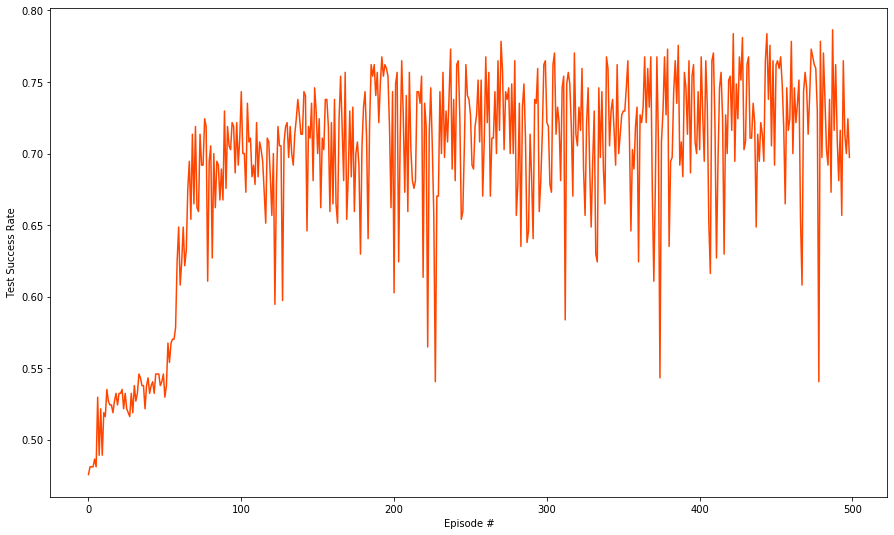

In [8]:

if __name__ == '__main__':
    success_list=[]
    since = time.time()
    for epoch in range(1, total_epoch):
        epoch_start = time.time()
        train(epoch)
        m, s = divmod(time.time() - epoch_start, 60)
        print(f'Training time: {m:.0f}m {s:.0f}s')
        success_list.append(test())
        m, s = divmod(time.time() - epoch_start, 60)
        print(f'Testing time: {m:.0f}m {s:.0f}s')

    m, s = divmod(time.time() - since, 60)
    print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')
    figsize = 15,9
    figure, ax = plt.subplots(figsize=figsize)


    plt.plot(np.arange(len(success_list)), success_list, color='orangered' )

    plt.ylabel('Test Success Rate')
    plt.xlabel('Episode #')
    plt.savefig('hyperthyroidism_test_success_rate.png')
    plt.show()
